We perform an l-1 regression analysis with feature vectors as miRNA expressions and targets as pathologic stage mapped to numbers 1 to 9

In [1]:
import os
import pandas

mirna_src_dir = os.getcwd() + "/assn-mirna-luad/data/processed/mirna/"
clinical_src_dir = os.getcwd() + "/assn-mirna-luad/data/processed/clinical/"

mirna_df = pandas.read_csv(mirna_src_dir+'mirna.csv')
clinical_df = pandas.read_csv(clinical_src_dir+'clinical.csv')

"""
Here we select samples to use for our regression analyss
"""
matched_samples = pandas.merge(clinical_df, mirna_df, on='patient_barcode').dropna(subset=['pathologic_stage', 'hsa-mir-96', 'pathologic_M'])['patient_barcode']
print "matched_samples", matched_samples.shape
# merged = pandas.merge(clinical_df, mirna_df, on='patient_barcode')
# print merged.shape
# print merged['histological_type'].value_counts().sort_index(axis=0)
# print merged['pathologic_stage'].value_counts().sort_index(axis=0)
# print merged['pathologic_T'].value_counts().sort_index(axis=0)
# print merged['pathologic_N'].value_counts().sort_index(axis=0)
# print merged['pathologic_M'].value_counts().sort_index(axis=0)

matched_samples (503,)


Do a simple miRNA feature selection with target values as the pathologic stage mapped to number range 1-9 based on guide from 

http://www.cancer.org/cancer/lungcancer-non-smallcell/detailedguide/non-small-cell-lung-cancer-staging

In [2]:
pathologic_stage_map = {'Stage I': 1, 'Stage IA': 1, 'Stage IB': 2, 
                        'Stage II': 3, 'Stage IIA': 3, 'Stage IIB': 4, 
                        'Stage IIIA': 6, 'Stage IIIB': 7, 
                        'Stage IV': 10}
pathologic_T_map = {'T1': 2, 'T1a': 1, 'T1b': 3, 'T2': 6, 'T2a': 5, 'T2b': 8, 'T3': 11, 'T4': 18, 'TX': 0}
pathologic_N_map = {'N0': 0, 'N1': 2, 'N2': 5, 'N3': 9, 'NX': 0}
pathologic_M_map = {'M0': 0, 'M1': 10, 'M1a': 7, 'M1b': 10, 'MX': 0}
clinical_df.replace({'pathologic_stage': pathologic_stage_map, 'pathologic_T': pathologic_T_map, 
                     'pathologic_N': pathologic_N_map, 'pathologic_M': pathologic_M_map}, inplace=True)

Prepare training & testing data

In [86]:
from sklearn import preprocessing

X = mirna_df[mirna_df['patient_barcode'].isin(matched_samples)]
X.__delitem__('patient_barcode')
Y = clinical_df[clinical_df['patient_barcode'].isin(matched_samples)]['pathologic_stage']
print 'miRNA null values', X.isnull().sum().sum()
print 'pathologic null values', Y.isnull().sum()
print 'X.shape', X.shape
print 'Y.shape', Y.shape
mirna_list = X.columns.values

X_scaler = preprocessing.StandardScaler(with_mean=False).fit(X)
X = X_scaler.transform(X)
# Y_scaler = preprocessing.StandardScaler().fit(Y)
# Y = Y_scaler.transform(Y)

miRNA null values 0
pathologic null values 0
X.shape (503, 1881)
Y.shape (503,)


Perform LASSO feature selection with cross-validation to find best model

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, Y.as_matrix(), test_size=0.1, random_state=np.random.randint(0, 10000))
print 'X_train', X_train.shape, ', y_train', y_train.shape
print 'X_test', X_test.shape, ', y_test', y_test.shape

model = linear_model.LassoCV(cv=9, fit_intercept=False, normalize=False)
print model.fit(X_train, y_train)

print "\nMSE train:", mean_squared_error(y_train, model.predict(X=X_train))
print "MSE test:", mean_squared_error(y_test, model.predict(X=X_test))

print "\nNon-zero coef:", np.nonzero(model.coef_)[0].size
print "miRNA's selected:\n", mirna_list[np.nonzero(model.coef_)[0]]
print "miRNA's corresponding coefficients:\n", model.coef_[np.nonzero(model.coef_)[0]]
# plt.hist(model.coef_, bins=100)
# plt.show()

X_train (452, 1881) , y_train (452,)
X_test (51, 1881) , y_test (51,)


LassoCV(alphas=None, copy_X=True, cv=9, eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

MSE train: 6.79004010206
MSE test: 6.65874698904

Non-zero coef: 25
miRNA's selected:
['hsa-mir-103a-2' 'hsa-mir-106a' 'hsa-mir-107' 'hsa-mir-132' 'hsa-mir-139'
 'hsa-mir-143' 'hsa-mir-1827' 'hsa-mir-190a' 'hsa-mir-21' 'hsa-mir-2110'
 'hsa-mir-22' 'hsa-mir-23a' 'hsa-mir-24-2' 'hsa-mir-30a' 'hsa-mir-335'
 'hsa-mir-3609' 'hsa-mir-3653' 'hsa-mir-374c' 'hsa-mir-378c' 'hsa-mir-4324'
 'hsa-mir-4429' 'hsa-mir-5703' 'hsa-mir-628' 'hsa-mir-890' 'hsa-mir-891b']
miRNA's corresponding coefficients:
[ 0.00596244  0.15116461  0.23922304  0.12390786  0.03695648  0.09574651
  0.00365352  0.00875486  0.49224558  0.02042981  0.04548747  0.01957883
  0.0071879   0.18070029  0.0179354   0.02840697  0.09662159  0.00922777
  0.0073844   0.02655928  0.02597257  0.0945408

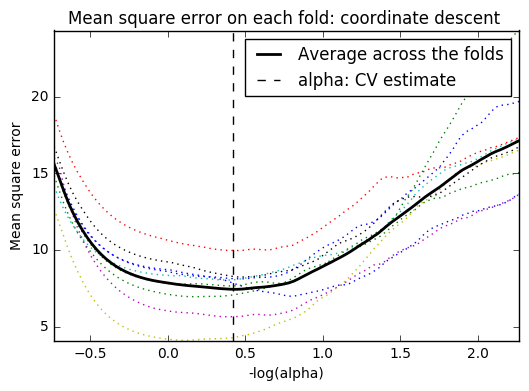

In [117]:
from matplotlib import pyplot as plt
# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.show()

In [81]:
# plt.spy(model.coef_)
# plt.xlabel('Feature')
# plt.ylabel('Time (or Task)')
# plt.show()

a few samples predicted:    [1, 2, 1, 4, 1, 1, 2, 3, 1, 2, 2, 5, 1, 2, 1, 2, 1, 1, 4, 4]
a few samples ground truth: [1, 4, 4, 3, 2, 1, 4, 1, 2, 1, 4, 1, 2, 6, 1, 4, 2, 7, 2, 3]


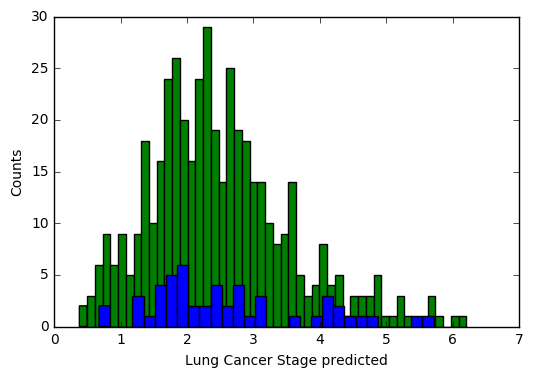

In [118]:
print "a few samples predicted:   ", np.array(model.predict(X=X_test)[0:20], dtype=np.int).tolist()
print "a few samples ground truth:", np.array(y_test[0:20], dtype=np.int).tolist()
# plt.hist(Y, bins=100, label="Original Y")
plt.hist(model.predict(X=X_train), bins=50, color='g', label="Train predicts")
plt.hist(model.predict(X=X_test), bins=30, color='b', label='Test predicts')
plt.xlabel('Lung Cancer Stage predicted')
plt.ylabel('Counts')
plt.show()